In [61]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
from torchvision.models import vgg16
from PIL import Image
%matplotlib inline

Q1 - Loading the model

In [62]:
model = vgg16(pretrained=True, progress=True)
model.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

preprocess = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


Q2 - 2 Images

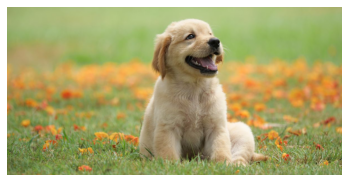

In [63]:
dog = cv2.imread('my_data/dog.jpg')
plt.imshow(cv2.cvtColor(dog, cv2.COLOR_BGR2RGB))
_ = plt.axis('off')

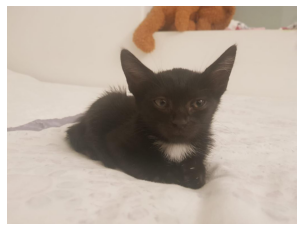

In [64]:
soda = cv2.imread('my_data/soda.jpeg')
plt.imshow(cv2.cvtColor(soda, cv2.COLOR_BGR2RGB))
_ = plt.axis('off')

Q3 - Pre-Processing the images

In [65]:
dog_tensor = preprocess(dog).unsqueeze(0).to(device)
soda_tensor = preprocess(soda).unsqueeze(0).to(device)

Q4 - Forward pass

In [66]:
with torch.no_grad():
    output_dog = model(dog_tensor)[0].argmax()
    output_soda = model(soda_tensor)[0].argmax()

import ast
text = open("data/imagenet1000_clsidx_to_labels.txt","r").read()
classes = ast.literal_eval(text)

print(classes[output_dog.item()])
print(classes[output_soda.item()])

Arctic fox, white fox, Alopex lagopus
Pomeranian


Q5 - segmentation

background
cat
dog
sheep


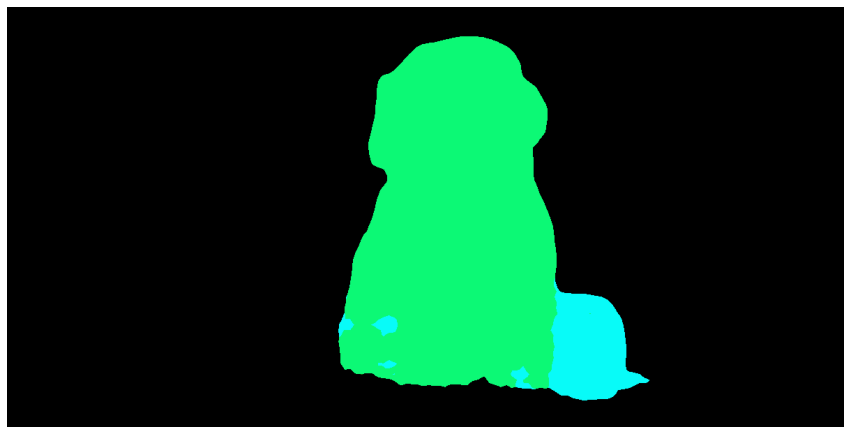

In [70]:
from torchvision.models.segmentation import fcn_resnet50

dog2 = Image.open('my_data/dog.jpg')

dog2_tensor = preprocess(dog2).unsqueeze(0).to(device)

seg_model = fcn_resnet50(pretrained=True)
seg_model.eval()

seg_model.to(device)

with torch.no_grad():
    output = seg_model(dog2_tensor)['out'][0]

output_predictions = output.argmax(0)

palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(dog2.size)
r.putpalette(colors)

# plot
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.imshow(r)
ax.set_axis_off()

labels = ['background', 'aeroplane',  'bicycle', 'bird',  'boat',      'bottle',
        'bus',        'car',      'cat',  'chair',     'cow',
        'diningtable','dog',    'horse',  'motorbike', 'person',
        'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

# what labels were recognized?
for label in np.unique(output_predictions.cpu().numpy()):
    print(labels[label])

Q6 - Different background

In [76]:
# cutting_dog = cv2.imread("my_data/dog.jpg", -1)
mask = torch.zeros_like(output_predictions).float().to(device)
mask[output_predictions != 0] = 1
masked_dog = dog * mask.unsqueeze(2).byte().cpu().numpy()

moon = cv2.imread('data/moon.jpg')
x_offset=y_offset=0
moon[y_offset:y_offset+dog.shape[0], x_offset:x_offset+dog.shape[1]] = dog

plt.imshow(cv2.cvtColor(moon, cv2.COLOR_BGR2RGB))
_ = plt.axis('off')


ValueError: could not broadcast input array from shape (602,1200,3) into shape (602,988,3)